In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.io import arff
import xgboost as xgb

# Scikit-learn 工具
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, auc, precision_recall_curve

# 模型
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE

# 设置绘图风格
sns.set(style="whitegrid", palette="muted")
import warnings
warnings.filterwarnings('ignore')

# 核心配置
FILE_PATH = 'data/processed/TimeBasedFeatures-Dataset-15s-VPN.arff' # 请确认路径正确
RANDOM_STATE = 42
N_JOBS = -1

In [7]:
import os
import pandas as pd
import numpy as np
from scipy.io import arff

# 定义要分析的文件列表
file_names = [
    'TimeBasedFeatures-Dataset-15s-VPN.arff',
]

# 假设文件在当前目录下，如果不在，请修改 path_to_files
path_to_files = 'data/processed' 

def decode_byte_strings(df):
    """
    ARFF加载后字符串通常是byte格式 (b'value')，
    此函数将其转换为普通字符串。
    """
    str_df = df.select_dtypes([object])
    str_df = str_df.stack().str.decode('utf-8').unstack()
    for col in str_df:
        df[col] = str_df[col]
    return df

def analyze_dataset(file_path):
    print("=" * 60)
    print(f"正在分析文件: {os.path.basename(file_path)}")
    print("=" * 60)

    try:
        # 加载 ARFF 文件
        data, meta = arff.loadarff(file_path)
        df = pd.DataFrame(data)
        
        # 处理字节字符串解码
        df = decode_byte_strings(df)
        
        # 1. 基础信息
        print(f"--- 1. 数据集形状 (Shape) ---")
        print(f"行数 (样本数): {df.shape[0]}")
        print(f"列数 (特征数): {df.shape[1]}")
        print("-" * 30)

        # 2. 类别分布 (检查数据是否平衡)
        # ISCX 数据集通常最后一列是标签 (比如 'class1')
        target_col = df.columns[-1] 
        print(f"--- 2. 类别分布 (Target Column: {target_col}) ---")
        class_counts = df[target_col].value_counts()
        class_percent = df[target_col].value_counts(normalize=True) * 100
        
        dist_df = pd.DataFrame({'Count': class_counts, 'Percentage (%)': class_percent})
        print(dist_df)
        
        # 检查是否存在严重的类别不平衡 (例如某一类占比低于 5%)
        if (class_percent < 5).any():
            print("\n[!] 警告: 检测到严重的数据偏斜 (Class Imbalance)！有类别占比低于 5%。")
        print("-" * 30)

        # 3. 特殊值检测 (NaN, Inf, 0, 负数)
        print(f"--- 3. 特殊值检测 ---")
        
        # 选择数值型列进行分析
        numeric_df = df.select_dtypes(include=[np.number])
        
        # 检查 NaN
        nan_counts = numeric_df.isna().sum().sum()
        # 检查 Infinity
        inf_counts = np.isinf(numeric_df).values.sum()
        
        print(f"缺失值 (NaN) 总数: {nan_counts}")
        print(f"无穷值 (Inf) 总数: {inf_counts}")

        # 检查 0 值
        zeros = (numeric_df == 0).sum()
        zero_cols = zeros[zeros > 0]
        if not zero_cols.empty:
            print(f"\n[i] 包含 0 值的列 (Top 5):")
            print(zero_cols.sort_values(ascending=False).head(5))
        else:
            print("没有包含 0 的数值列。")

        # 检查负数 (网络流特征通常不应为负，除非是标准化后的数据)
        negatives = (numeric_df < 0).sum()
        neg_cols = negatives[negatives > 0]
        if not neg_cols.empty:
            print(f"\n[!] 警告: 检测到负数值 (可能异常，取决于特征定义):")
            print(neg_cols.sort_values(ascending=False))
        else:
            print("\n[OK] 未检测到负数。")
        print("-" * 30)

        # 4. 数据偏斜度 (Skewness) 分析
        print(f"--- 4. 特征偏斜度 (Skewness) ---")
        # 计算偏斜度: 0=正态, >1 or <-1=高度偏斜
        skewness = numeric_df.skew()
        
        high_skew = skewness[abs(skewness) > 1]
        
        print(f"高度偏斜的特征数量 (|Skew| > 1): {len(high_skew)} / {len(numeric_df.columns)}")
        
        if not high_skew.empty:
            print("\n偏斜度最高的 5 个特征:")
            print(high_skew.abs().sort_values(ascending=False).head(5))
            print("\n(注: 正值表示右偏/长尾，负值表示左偏)")
        
        # 5. 描述性统计摘要
        print("-" * 30)
        print(f"--- 5. 统计摘要 (部分) ---")
        print(numeric_df.describe().loc[['mean', 'std', 'min', 'max']].iloc[:, :4]) # 只显示前4列避免刷屏
        print("..." + f" (共 {len(numeric_df.columns)} 列)")
        
        print("\n\n")

    except FileNotFoundError:
        print(f"[ERROR] 找不到文件: {file_path}")
    except Exception as e:
        print(f"[ERROR] 处理文件 {file_path} 时发生错误: {e}")

# 主程序循环
for fname in file_names:
    full_path = os.path.join(path_to_files, fname)
    analyze_dataset(full_path)

正在分析文件: TimeBasedFeatures-Dataset-15s-VPN.arff
--- 1. 数据集形状 (Shape) ---
行数 (样本数): 18758
列数 (特征数): 24
------------------------------
--- 2. 类别分布 (Target Column: class1) ---
         Count  Percentage (%)
class1                        
VPN       9793       52.207058
Non-VPN   8965       47.792942
------------------------------
--- 3. 特殊值检测 ---
缺失值 (NaN) 总数: 0
无穷值 (Inf) 总数: 0

[i] 包含 0 值的列 (Top 5):
std_active     14935
std_idle       14935
mean_active    11355
mean_idle      11355
mean_biat       5034
dtype: int64

[!] 警告: 检测到负数值 (可能异常，取决于特征定义):
min_idle       11355
max_idle       11355
max_active     11355
min_active     11355
min_biat        3637
total_biat      3637
total_fiat      2641
min_fiat        2641
min_flowiat      708
max_flowiat      532
dtype: int64
------------------------------
--- 4. 特征偏斜度 (Skewness) ---
高度偏斜的特征数量 (|Skew| > 1): 23 / 23

偏斜度最高的 5 个特征:
flowBytesPerSecond    57.518702
std_idle              34.377980
std_active            33.346030
min_biat              32.9

In [3]:
def load_and_preprocess(file_path):
    # --- 1. 加载 ARFF ---
    print(f"📂 Loading data from: {file_path}")
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)
    
    # 解码 byte 字符串
    str_cols = df.select_dtypes([object]).columns
    for col in str_cols:
        df[col] = df[col].str.decode('utf-8')

    # --- 2. 标签处理 ---
    target_col = df.columns[-1]
    print(f"   -> Target column identified: '{target_col}'")
    
    # 定义标签映射逻辑 (Non-VPN -> 0, VPN -> 1)
    def map_label(label):
        label_str = str(label).lower()
        if 'non-vpn' in label_str: return 0
        if 'vpn' in label_str or 'tor' in label_str: return 1
        return 0

    df['Binary_Label'] = df[target_col].apply(map_label)
    
    # 打印分布
    y = df['Binary_Label']
    print(f"   -> Class Distribution: Normal(0)={sum(y==0)}, VPN(1)={sum(y==1)}")

    # --- 3. 特征提取 ---
    cols_to_drop = [target_col, 'Binary_Label']
    X = df.drop(columns=cols_to_drop)
    
    # 清洗数值 (NaN/Inf)
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    X = X.replace([np.inf, -np.inf], 0)
    
    return X, y, X.columns.tolist()

In [4]:
# 1. 加载数据
X_raw, y, feat_names = load_and_preprocess(FILE_PATH)

# 2. 划分训练集/测试集 (7:3)
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

# 3. 全局标准化 (这对 MLP 和 Stacking 至关重要)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 保持 DataFrame 格式以便后续通过列名索引 (可选，方便调试)
X_train_df = pd.DataFrame(X_train_scaled, columns=feat_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feat_names)

print("\n✅ Data Pipeline Ready.")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Testing samples:  {X_test.shape[0]}")

📂 Loading data from: data/processed/TimeBasedFeatures-Dataset-15s-VPN.arff
   -> Target column identified: 'class1'
   -> Class Distribution: Normal(0)=8965, VPN(1)=9793

✅ Data Pipeline Ready.
   Training samples: 13130
   Testing samples:  5628


🚀 Training Baseline Random Forest...
   -> Baseline Accuracy: 0.9172
   -> Baseline F1-Score: 0.9222
🎨 Generating t-SNE plot...


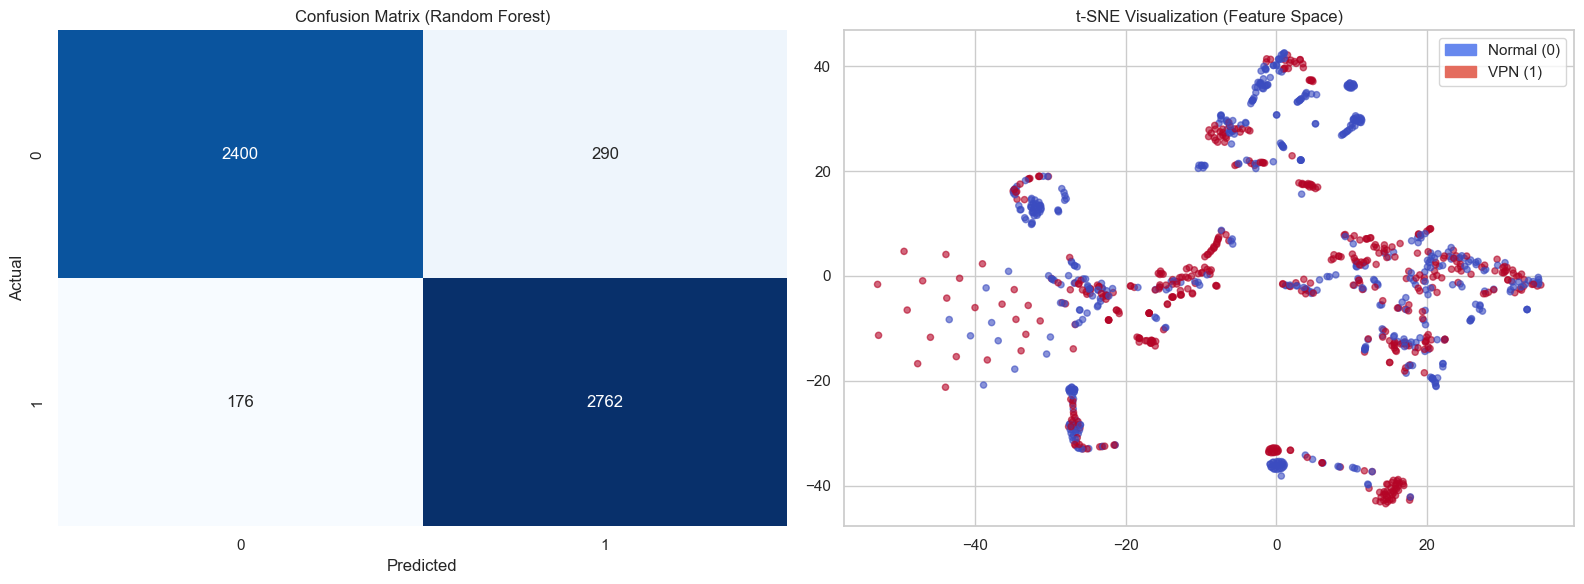

In [5]:
# --- 1. 训练基准 RF ---
print("🚀 Training Baseline Random Forest...")
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=N_JOBS)
rf_baseline.fit(X_train_scaled, y_train)
y_pred_rf = rf_baseline.predict(X_test_scaled)

print(f"   -> Baseline Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"   -> Baseline F1-Score: {f1_score(y_test, y_pred_rf):.4f}")

# --- 2. 可视化 ---
plt.figure(figsize=(16, 6))

# Subplot 1: 混淆矩阵
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted'); plt.ylabel('Actual')

# Subplot 2: t-SNE 降维可视化 (采样 1000 个点)
print("🎨 Generating t-SNE plot...")
plt.subplot(1, 2, 2)
sample_idx = np.random.choice(len(X_train_scaled), min(1000, len(X_train_scaled)), replace=False)
X_sample = X_train_scaled[sample_idx]
y_sample = y_train.iloc[sample_idx]

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
X_embedded = tsne.fit_transform(X_sample)

scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_sample, cmap='coolwarm', alpha=0.6, s=20)
plt.legend(handles=[mpatches.Patch(color='#6788ee', label='Normal (0)'), 
                    mpatches.Patch(color='#e46c5e', label='VPN (1)')])
plt.title('t-SNE Visualization (Feature Space)')

plt.tight_layout()
plt.show()

⚔️ Comparing Advanced Models...
   -> Random Forest: F1=0.9222, AUC=0.9749
   -> XGBoost: F1=0.9236, AUC=0.9784
   -> MLP (Neural Net): F1=0.7511, AUC=0.8250


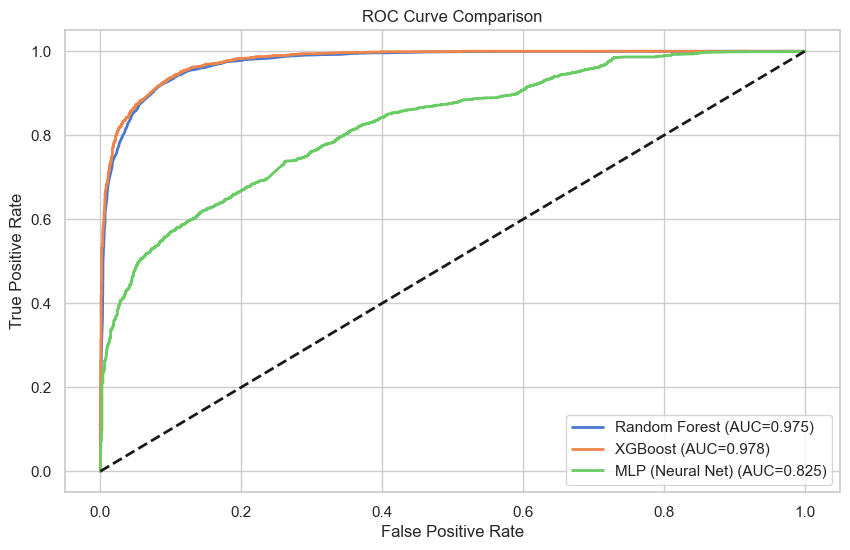

,Model,F1,AUC
1,XGBoost,0.923567,0.978417
0,Random Forest,0.922204,0.974904
2,MLP (Neural Net),0.751142,0.825022


In [6]:
print("⚔️ Comparing Advanced Models...")

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=N_JOBS),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE, n_jobs=N_JOBS),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=RANDOM_STATE)
}

results = []
plt.figure(figsize=(10, 6))

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # 计算 ROC
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # 记录
    f1 = f1_score(y_test, y_pred)
    results.append({"Model": name, "F1": f1, "AUC": roc_auc})
    print(f"   -> {name}: F1={f1:.4f}, AUC={roc_auc:.4f}")
    
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC={roc_auc:.3f})')

# 绘图
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

# 展示榜单
pd.DataFrame(results).sort_values(by="F1", ascending=False)

In [ ]:
print("🔧 Tuning Random Forest Hyperparameters...")

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_base = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS)
grid = GridSearchCV(rf_base, param_grid, cv=3, scoring='f1', n_jobs=N_JOBS, verbose=1)
grid.fit(X_train_scaled, y_train)

best_rf = grid.best_estimator_
best_params = grid.best_params_

print(f"\n✅ Best Params: {best_params}")
print(f"   Best CV F1: {grid.best_score_:.4f}")
print(f"   Test Set F1: {f1_score(y_test, best_rf.predict(X_test_scaled)):.4f}")

In [ ]:
print("⚖️ Final Stability Check (5-Fold Stratified CV)...")

# 定义选手
model_default = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=N_JOBS)
model_tuned = best_rf # 使用上面微调出的最佳模型

# 定义裁判 (必须 Shuffle 以打破时间序列相关性)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 比赛
scores_def = cross_val_score(model_default, X_raw, y, cv=cv, scoring='f1', n_jobs=N_JOBS) # 注意用 X_raw
scores_tun = cross_val_score(model_tuned, X_raw, y, cv=cv, scoring='f1', n_jobs=N_JOBS)

# 结果可视化
res_df = pd.DataFrame({'Default RF': scores_def, 'Tuned RF': scores_tun})

plt.figure(figsize=(8, 5))
sns.boxplot(data=res_df, palette="Set3", width=0.5)
sns.stripplot(data=res_df, color=".25", size=5)
plt.title(f'Stability Analysis (Mean F1: Tuned={scores_tun.mean():.4f})')
plt.ylabel('F1 Score')
plt.show()

In [ ]:
print("🧱 Building Final Stacking Ensemble...")

# 1. 基学习器 (利用之前的最佳参数 + 互补模型)
estimators = [
    ('rf', best_rf), # 微调后的 RF
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE, n_jobs=N_JOBS)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=RANDOM_STATE))
]

# 2. 元学习器
final_estimator = LogisticRegression()

# 3. 训练 Stacking
clf_stack = StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=5, n_jobs=N_JOBS)
clf_stack.fit(X_train_scaled, y_train)

# 4. 评估
y_pred_stack = clf_stack.predict(X_test_scaled)
stack_f1 = f1_score(y_test, y_pred_stack)

print(f"✅ Final Stacking F1-Score: {stack_f1:.4f}")

In [ ]:
from sklearn.model_selection import cross_val_predict

print("🎯 [Step 9] Optimizing Threshold via Cross-Validation (Leakage-Free)...")

# 1. 获取训练集的“交叉验证预测概率” (Out-of-Fold Predictions)
# 这模拟了“模型没见过这些数据”时的预测表现
# 注意：这里用的是 X_train_scaled 和 y_train
y_prob_train_cv = cross_val_predict(clf_stack, X_train_scaled, y_train, cv=5, method='predict_proba', n_jobs=N_JOBS)[:, 1]

# 2. 在训练集上搜索最佳阈值
precisions, recalls, thresholds = precision_recall_curve(y_train, y_prob_train_cv)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = np.nan_to_num(f1_scores) # 处理可能出现的 NaN

best_idx = np.argmax(f1_scores)
best_thresh_cv = thresholds[best_idx]
best_f1_cv = f1_scores[best_idx]

print(f"   -> Best Threshold found on CV: {best_thresh_cv:.4f}")
print(f"   -> Max CV F1-Score at this threshold: {best_f1_cv:.4f}")

# 3. 将这个阈值应用到测试集 (Test Set)
# 这才是真正的“最终成绩”
y_prob_test = clf_stack.predict_proba(X_test_scaled)[:, 1]
y_pred_final = (y_prob_test >= best_thresh_cv).astype(int)

final_f1_test = f1_score(y_test, y_pred_final)
final_acc_test = accuracy_score(y_test, y_pred_final)

print("\n🏆 Final Unbiased Test Results:")
print(f"   -> Accuracy: {final_acc_test:.4f}")
print(f"   -> F1-Score: {final_f1_test:.4f} (at threshold {best_thresh_cv:.4f})")

# 4. 可视化
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores[:-1], label='CV F1 Score', color='navy')
plt.axvline(best_thresh_cv, color='red', linestyle='--', label=f'Optimized Threshold: {best_thresh_cv:.2f}')
plt.title('Threshold Optimization using Training CV Data')
plt.xlabel('Threshold'); plt.ylabel('F1 Score')
plt.legend(); plt.show()

In [ ]:
import joblib
import os

print("📦 [Step 10] Exporting Final Model Artifacts...")

# 1. 创建导出目录
os.makedirs('models', exist_ok=True)

# 2. 打包所有关键组件
# 我们不仅保存模型，还要保存 Scaler (用于新数据归一化) 和 阈值
model_artifacts = {
'model_name': 'Stacking_Ensemble_VPN_Detector',
'version': '1.0',
'classifier': clf_stack,         # 训练好的 Stacking 模型
'scaler': scaler,                # 训练好的标准化器
'threshold': best_thresh_cv,     # CV 验证出的最佳阈值
'feature_names': feat_names      # 特征名称列表 (防止特征顺序搞错)
}

# 3. 保存文件
save_path = 'models/vpn_detection_final.pkl'
joblib.dump(model_artifacts, save_path)

print(f"✅ Model saved successfully at: {save_path}")
print("   Content included:")
print(f"   - Classifier: {type(clf_stack).__name__}")
print(f"   - Scaler: {type(scaler).__name__}")
print(f"   - Optimized Threshold: {best_thresh_cv:.4f}")
print(f"   - Feature Columns: {len(feat_names)}")